<a href="https://colab.research.google.com/github/VictoriaPedrozaAI/chatbot_fashion/blob/main/MultimodalFashionChat_V3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#CELL 1:  DEPENDENCIES

!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets faiss-cpu
!pip install -q streamlit librosa soundfile
!pip install -q Pillow pandas numpy tqdm

# Unsloth for efficient LLM inference
!pip install -q unsloth
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes

print("✅ All dependencies installed!")
#If prompted, restart runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 744.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# CELL 2: IMPORTS AND CONFIGURATION

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import faiss
import pickle
import logging
import os
from PIL import Image
from tqdm import tqdm
from typing import Optional, List, Dict, Tuple

# Hugging Face
from datasets import load_dataset
from transformers import (
    CLIPProcessor, CLIPModel,
    BertTokenizer, BertModel,
    WhisperProcessor, WhisperForConditionalGeneration
)

# Audio processing
import librosa

# logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Device configuration CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {DEVICE}")

# Configuration CLIP/BERT/WHISPER/UNSLOTH
CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "BERT_MODEL": "bert-base-uncased",
    "WHISPER_MODEL": "openai/whisper-base",
    "LLM_MODEL": "unsloth/Qwen2.5-7B-Instruct-bnb-4bit",
    "EMBEDDING_DIM": 512,
    "MAX_TEXT_LENGTH": 128,
    "TOP_K_RESULTS": 10,
    "NUM_INTENTS": 5
}

# Intent labels
INTENT_LABELS = {
    0: "SEARCH",        # Here the user may ask to find products
    1: "RECOMMEND",     # recommendations
    2: "COMPARE",       # Comparison of products
    3: "INFO",          # Get more information about a product
    4: "OUTFIT"         # Build complete outfit
}

print(" Configuration loaded!")

🖥️ Using device: cuda
 Configuration loaded!


In [ ]:
# CELL 3:FASHIONPEDIA DATASET

from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

print("...Loading Fashionpedia dataset...")

# Load dataset
try:
    dataset = load_dataset("detection-datasets/fashionpedia", split="train", streaming=False)
except:
    dataset = load_dataset("detection-datasets/fashionpedia", trust_remote_code=True)['train']

# Category List
CATEGORY_NAMES = [
    "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket",
    "vest", "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape",
    "glasses", "hat", "headband, head covering, hair accessory", "tie", "glove",
    "watch", "belt", "leg warmer", "tights, stockings", "sock", "shoe", "bag, wallet",
    "scarf", "umbrella", "hood", "collar", "lapel", "epaulette", "sleeve", "pocket",
    "neckline", "buckle", "zipper", "applique", "bead", "bow", "flower", "fringe",
    "ribbon", "rivet", "ruffle", "sequin", "tassel"
]

# Groups
MAIN_GARMENTS = set(range(0, 13))
ACCESSORIES = set(range(13, 27))

def safe_process_item(item, idx):
    try:
        image = item.get('image')
        if image is None: return None

        # 1. Convertion to PIL RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')
        else:
            image = image.convert('RGB')

        # 2. RESIZE limit max dimension 256px to save RAM

        image.thumbnail((256, 256))

        # 3. Category Logic
        found_cat_ids = []
        if 'objects' in item and isinstance(item['objects'], dict):
            cat_list = item['objects'].get('category', [])
            if isinstance(cat_list, list):
                found_cat_ids = cat_list

        if not found_cat_ids and 'category' in item:
            found_cat_ids = [item['category']]

        primary_cat_id = -1

        #  Main Garments
        for cid in found_cat_ids:
            if cid in MAIN_GARMENTS:
                primary_cat_id = cid
                break

        # Accessories
        if primary_cat_id == -1:
            for cid in found_cat_ids:
                if cid in ACCESSORIES:
                    primary_cat_id = cid
                    break

        #  Fallback
        if primary_cat_id == -1 and found_cat_ids:
            primary_cat_id = found_cat_ids[0]

        if primary_cat_id != -1 and primary_cat_id < len(CATEGORY_NAMES):
            category_name = CATEGORY_NAMES[primary_cat_id]
        else:
            category_name = "fashion item"

        return {
            'id': str(idx),
            'image': image,
            'name': category_name.split(',')[0].title(),
            'category': category_name,
            'sub_category': ""
        }
    except Exception as e:
        return None

# CONFIGURATION
MAX_ITEMS = 3000  # Set to 3000 Because the RAM crashed

print(f"\n Processing {MAX_ITEMS}...")
processed_items = []

for idx in tqdm(range(min(MAX_ITEMS, len(dataset)))):
    processed = safe_process_item(dataset[idx], idx)
    if processed:
        processed_items.append(processed)

print(f"\n Successfully processed {len(processed_items)} ")

...Loading Fashionpedia dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00007-fe108070118553(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00001-of-00007-f41a5a9c38c900(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00002-of-00007-40bc8456894bcb(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00003-of-00007-9a99ff8dc572e0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00004-of-00007-f4e6f12cd2cedf(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00005-of-00007-41d8dfe1edb659(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00006-of-00007-f41b0f2f4bbefa(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/val-00000-of-00001-0b29e85429788213(…):   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]


 Processing 3000...


100%|██████████| 3000/3000 [00:25<00:00, 115.81it/s]


 Successfully processed 3000 


 Starting EDA...
Dataset Size: 3000 items
Unique Categories: 19


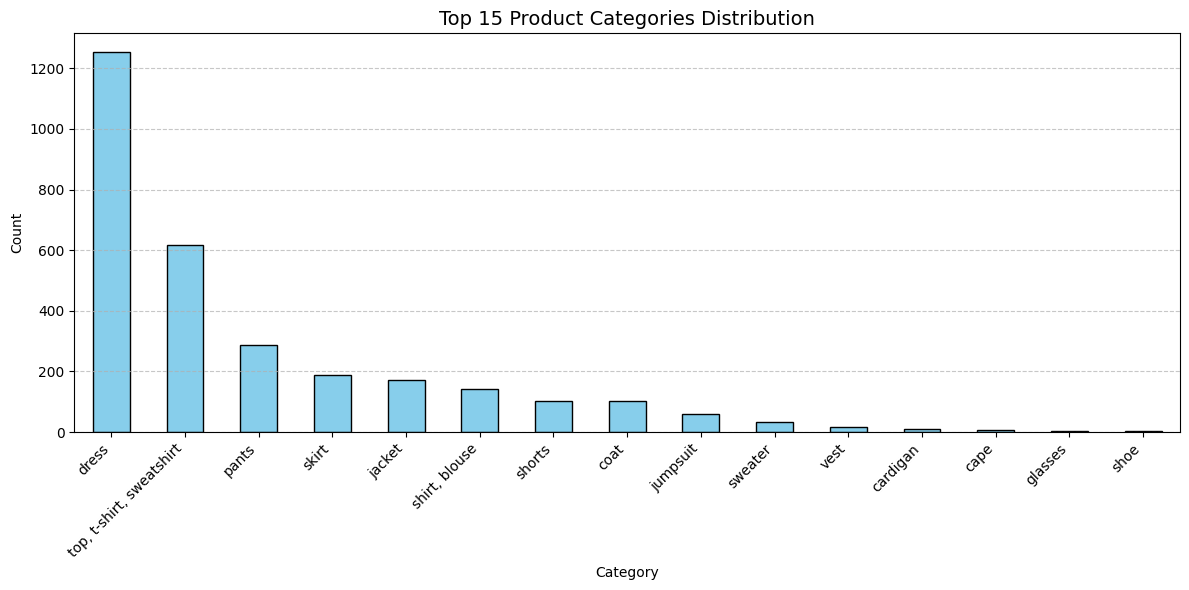

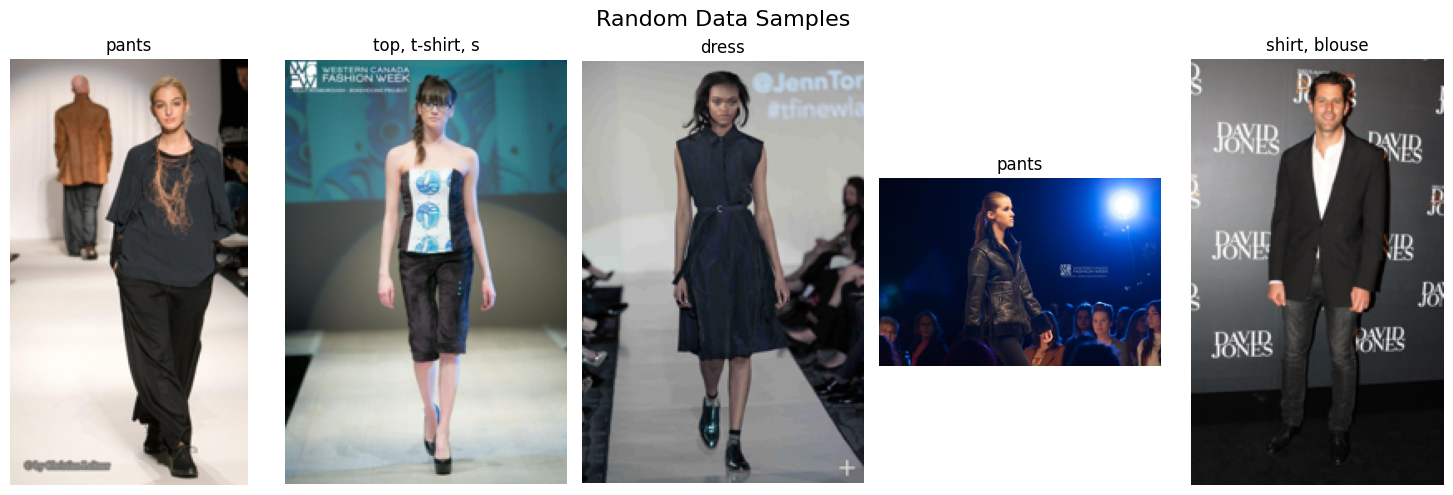

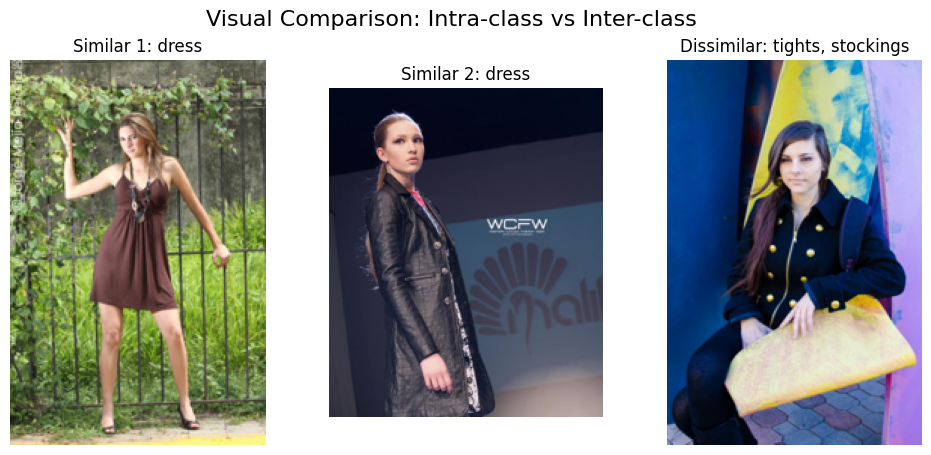

 EDA Complete


In [ ]:
# CELL 3B: EDA
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

print(" Starting EDA...")

# 1. DataFrame for Analysis
df_eda = pd.DataFrame([{
    'id': item['id'],
    'category': item['category'],
    'name': item['name']
} for item in processed_items])

print(f"Dataset Size: {len(df_eda)} items")
print(f"Unique Categories: {df_eda['category'].nunique()}")

# 2. PLOT CLASS DISTRIBUTION (categories, colours, styles)
plt.figure(figsize=(12, 6))
top_categories = df_eda['category'].value_counts().head(15)
top_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Product Categories Distribution', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. SAMPLES (
def show_samples(items, num_samples=5):
    plt.figure(figsize=(15, 5))
    samples = random.sample(items, num_samples)

    for i, item in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(item['image'])
        plt.title(item['category'][:15]) # Truncate long names
        plt.axis('off')

    plt.suptitle(f"Random Data Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(processed_items)

# 4. COMPARISON SIMILAR VS DISSIMILAR PRODUCTS
def compare_items(items):
    # Find two items of the same category to plot Similar
    cat_counts = df_eda['category'].value_counts()
    common_cat = cat_counts.index[0] # Most common category

    similar_indices = df_eda[df_eda['category'] == common_cat].index[:2].tolist()
    similar_items = [items[i] for i in similar_indices]

    # Find one item of a very different category
    diff_cat = cat_counts.index[-1]
    diff_index = df_eda[df_eda['category'] == diff_cat].index[0]
    diff_item = items[diff_index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Similar 1
    axes[0].imshow(similar_items[0]['image'])
    axes[0].set_title(f"Similar 1: {similar_items[0]['category']}")
    axes[0].axis('off')

    # Similar 2
    axes[1].imshow(similar_items[1]['image'])
    axes[1].set_title(f"Similar 2: {similar_items[1]['category']}")
    axes[1].axis('off')

    # Dissimilar
    axes[2].imshow(diff_item['image'])
    axes[2].set_title(f"Dissimilar: {diff_item['category']}")
    axes[2].axis('off')

    plt.suptitle("Visual Comparison: Intra-class vs Inter-class", fontsize=16)
    plt.show()

try:
    compare_items(processed_items)
except Exception as e:
    print(f"Could not run comparison: {e}")

print(" EDA Complete")

In [ ]:
# CELL 4: CLIP ENCODER FOR SEMANTIC SEARCH
import torch
import numpy as np
import logging
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "EMBEDDING_DIM": 512,
}

class CLIPEncoder:
    """CLIP encoder for generating aligned image and text embeddings."""

    def __init__(self, model_name: str = CONFIG["CLIP_MODEL"]):
        logger.info(f"Loading CLIP model: {model_name}")

        try:
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info(" CLIP model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load CLIP: {e}")
            raise

    @torch.no_grad()
    def encode_image(self, image: Image.Image) -> np.ndarray:
        try:
            inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Image encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    @torch.no_grad()
    def encode_text(self, text: str) -> np.ndarray:
        try:
            inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Text encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    def encode_multimodal(self, image=None, text: str = "") -> np.ndarray:
        embeddings = []
        if image is not None:
            embeddings.append(self.encode_image(image))
        if text and text.strip():
            embeddings.append(self.encode_text(text))
        if not embeddings:
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)
        combined = np.mean(embeddings, axis=0)
        return (combined / (np.linalg.norm(combined) + 1e-8)).astype(np.float32)

# Initialize
print(" Initializing CLIP encoder...")
clip_encoder = CLIPEncoder()
print(" CLIP encoder ready!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 Initializing CLIP encoder...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

 CLIP encoder ready!


In [ ]:
# CELL 5: BERT INTENT CLASSIFIER (forward method)

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import logging

logger = logging.getLogger(__name__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_INTENTS = 5
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

class IntentClassifier(nn.Module):
    """BERT-based intent classifier"""

    def __init__(self, num_intents: int = NUM_INTENTS):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_intents)
        self.to(DEVICE)

    def forward(self, input_ids, attention_mask):
        """Required forward method for PyTorch nn.Module"""
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [CLS] token
        logits = self.classifier(pooled)
        return logits

# Initialize
print(" Loading BERT Intent Classifier...")
intent_classifier = IntentClassifier()
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(" Intent classifier ready!")

# Test
test_text = "Show me summer dresses"
inputs = intent_tokenizer(test_text, return_tensors="pt", truncation=True).to(DEVICE)
with torch.no_grad():
    logits = intent_classifier(inputs["input_ids"], inputs["attention_mask"])
    pred = torch.argmax(logits, dim=1).item()
print(f"Test: '{test_text}' → Intent: {INTENT_LABELS[pred]}")

 Loading BERT Intent Classifier...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 Intent classifier ready!
Test: 'Show me summer dresses' → Intent: COMPARE


In [ ]:
# CELL 6: WHISPER AUDIO TRANSCRIPTION
import torch
import numpy as np
import logging
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger = logging.getLogger(__name__)

WHISPER_MODEL = "openai/whisper-base"

class AudioTranscriber:
    """Whisper-based audio transcription."""

    def __init__(self, model_name: str = WHISPER_MODEL):
        logger.info(f"Loading Whisper model: {model_name}")

        try:
            self.processor = WhisperProcessor.from_pretrained(model_name)
            self.model = WhisperForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info("Whisper model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            raise

    @torch.no_grad()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000):
        """Transcribe audio array to text"""
        try:
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features.to(DEVICE)

            predicted_ids = self.model.generate(input_features)
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True
            )[0]

            return transcription.strip()
        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            return None

    def transcribe_file(self, audio_path: str):
        """Transcribe audio file to text"""
        try:
            audio_array, sr = librosa.load(audio_path, sr=16000)
            return self.transcribe(audio_array, sampling_rate=16000)
        except Exception as e:
            logger.error(f"Failed to load audio file: {e}")
            return None

# Initialize
print("Initializing Whisper transcriber...")
audio_transcriber = AudioTranscriber()
print("Whisper transcriber ready!")

Initializing Whisper transcriber...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper transcriber ready!


In [ ]:
# CELL 7: BUILD FAISS INDEX
import faiss
import pickle
import numpy as np
import logging
from typing import List, Dict, Optional
from tqdm import tqdm
from PIL import Image

logger = logging.getLogger(__name__)
EMBEDDING_DIM = 512
TOP_K_RESULTS = 5

class FashionSearchIndex:
    """FAISS-based search index for fashion products."""

    def __init__(self, embedding_dim: int = EMBEDDING_DIM):
        self.embedding_dim = embedding_dim
        self.index = faiss.IndexFlatIP(embedding_dim)
        self.metadata = []
        self.images = {}

    def add_items(self, items: List[Dict], encoder, batch_size: int = 32):
        """Add items to the index"""
        logger.info(f"Indexing {len(items)} items...")

        all_embeddings = []

        for i, item in enumerate(tqdm(items, desc="Generating embeddings")):
            try:
                embedding = encoder.encode_image(item['image'])
                all_embeddings.append(embedding)

                self.metadata.append({
                    'id': item['id'],
                    'name': item['name'],
                    'category': item['category'],
                    'sub_category': item.get('sub_category', '')
                })

                self.images[item['id']] = item['image']

            except Exception as e:
                continue

        if all_embeddings:
            embedding_matrix = np.vstack(all_embeddings).astype('float32')
            self.index.add(embedding_matrix)
            logger.info(f" Indexed {self.index.ntotal} items")

    def search(self, query_embedding: np.ndarray, k: int = TOP_K_RESULTS) -> List[Dict]:
        """Search for similar items"""
        if self.index.ntotal == 0:
            return []

        query_embedding = query_embedding.reshape(1, -1).astype('float32')
        scores, indices = self.index.search(query_embedding, k)

        results = []
        for score, idx in zip(scores[0], indices[0]):
            if 0 <= idx < len(self.metadata):
                result = self.metadata[idx].copy()
                result['score'] = float(score)
                result['image'] = self.images.get(result['id'])
                results.append(result)

        return results

# Build index
print("Building FAISS search index...")
search_index = FashionSearchIndex()
search_index.add_items(processed_items, clip_encoder)

# Test search
print("\nTesting search...")
test_embedding = clip_encoder.encode_text("elegant black dress")
results = search_index.search(test_embedding, k=5)
print(f"Top 5 results:")
for i, r in enumerate(results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

# Negative Test
print("\n🔍 Negative Control Test...")
bad_query = clip_encoder.encode_text("a photo of a hamburger")
bad_results = search_index.search(bad_query, k=1)
print(f"Score for 'Hamburger' (Should be low): {bad_results[0]['score']:.4f}")

Building FAISS search index...


Generating embeddings: 100%|██████████| 3000/3000 [00:34<00:00, 85.92it/s]



Testing search...
Top 5 results:
   1. Dress (dress) - Score: 0.3051
   2. Dress (dress) - Score: 0.2964
   3. Dress (dress) - Score: 0.2956
   4. Dress (dress) - Score: 0.2915
   5. Dress (dress) - Score: 0.2877

🔍 Negative Control Test...
Score for 'Hamburger' (Should be low): 0.2647


In [ ]:
# CELL 7B: SAVE INDEX & DATA

import pickle
import io
from PIL import Image

def image_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=85)
    return buf.getvalue()

# Get products with images
save_data = {
    'index': faiss.serialize_index(search_index.index),
    'products': []
}

for i, meta in enumerate(search_index.metadata):
    product = {
        'name': meta['name'],
        'category': meta['category'],
        'image_bytes': None
    }

    # Get image from search_index.images using the ID
    item_id = meta.get('id', i)
    if item_id in search_index.images:
        img = search_index.images[item_id]
        if img:
            product['image_bytes'] = image_to_bytes(img)

    save_data['products'].append(product)

with open('fashion_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

# Verify
images_saved = sum(1 for p in save_data['products'] if p['image_bytes'])
print(f" Saved {len(save_data['products'])} products, {images_saved} with images")

 Saved 3000 products, 3000 with images


🚀 Initializing Training ...
🖥️ Using device: cuda
🏋️ Starting Real Fine-Tuning (Head Training)...
   📦 Training on 19 classes: ['cape', 'cardigan', 'coat', 'dress', 'glasses']...


Epoch 1/3: 100%|██████████| 94/94 [00:21<00:00,  4.32it/s, loss=0.426, acc=0.69]


   ✅ Epoch 1 Summary: Loss=1.2169, Accuracy=0.6903


Epoch 2/3: 100%|██████████| 94/94 [00:21<00:00,  4.36it/s, loss=0.172, acc=0.958]


   ✅ Epoch 2 Summary: Loss=0.2587, Accuracy=0.9580


Epoch 3/3: 100%|██████████| 94/94 [00:21<00:00,  4.29it/s, loss=0.315, acc=0.987]


   ✅ Epoch 3 Summary: Loss=0.0988, Accuracy=0.9870


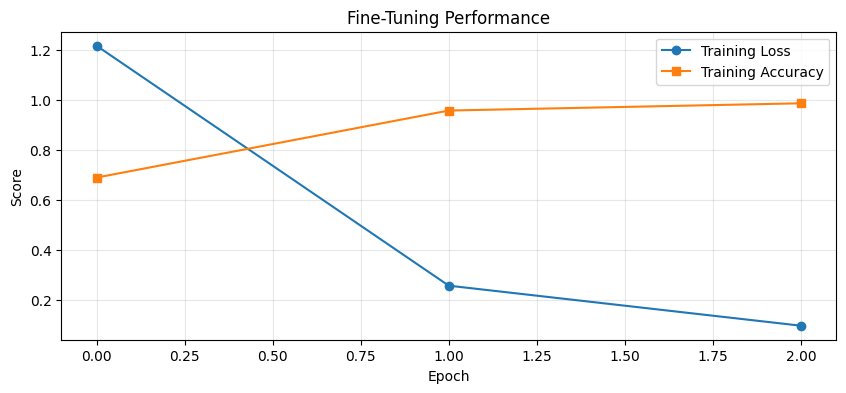

✅ Training complete!


In [ ]:
# CELL 7C: MULTIMODAL FINE-TUNING

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

print("🚀 Initializing Training ...")

# Device Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {DEVICE}")

# 1. DATASET WITH TOKENIZATION
class RealFashionDataset(Dataset):
    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # Create Label Mapping (Category Name -> Integer ID)
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

        print(f"   📦 Training on {self.num_classes} classes: {self.categories[:5]}...")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        try:
            item = self.items[idx]
            image = item['image']
            text = f"A photo of a {item['name']}"

            # 1. Image Transform (Augmentation)
            if self.transform:
                image = self.transform(image)

            # 2. Text Tokenization (CLIP Tokenizer)
            text_inputs = self.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77)

            label_id = self.label_map[item['category']]

            return {
                'image': image,
                'input_ids': text_inputs['input_ids'].squeeze(0),
                'attention_mask': text_inputs['attention_mask'].squeeze(0),
                'label': torch.tensor(label_id, dtype=torch.long)
            }
        except Exception as e:
            print(f"❌ Error at idx {idx}: {type(e).__name__}: {e}")
            # Return next valid sample to prevent crash
            return self.__getitem__((idx + 1) % len(self))

# 2. AUGMENTATION PIPELINE
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 256px thumbnail → 224px for CLIP
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275])
])

# 3. FUSION MODEL
class RealFusionNetwork(nn.Module):
    def __init__(self, backbone_model, num_classes):
        super().__init__()
        self.backbone = backbone_model

        # Freeze Backbone (Transfer Learning)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Fusion Head
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (Image) + 512 (Text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # 1. Get Real Features from Backbone (No Grad)
        with torch.no_grad():
            img_features = self.backbone.get_image_features(pixel_values=images)
            txt_features = self.backbone.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

            # Normalize
            img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
            txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)

        # 2. Concatenate
        combined = torch.cat((img_features, txt_features), dim=1)

        # 3. Classify
        logits = self.fusion_mlp(combined)
        return logits

# 4. TRAINING LOOP
def train_fusion(items, clip_model, clip_processor, epochs=2):
    print(f"🏋️ Starting Real Fine-Tuning (Head Training)...")

    try:
        # Setup Data
        dataset = RealFashionDataset(items, clip_processor, transform=train_transforms)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Setup Model
        model = RealFusionNetwork(clip_model, dataset.num_classes).to(DEVICE)

        # Optimizer (Only optimize the fusion_mlp parameters)
        optimizer = optim.Adam(model.fusion_mlp.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Metric History
        history = {'loss': [], 'accuracy': []}

        model.train()

        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

            for batch in progress_bar:
                # Move to GPU
                images = batch['image'].to(DEVICE)
                input_ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                # Zero Grad
                optimizer.zero_grad()

                # Forward
                outputs = model(images, input_ids, mask)
                loss = criterion(outputs, labels)

                # Backward
                loss.backward()
                optimizer.step()

                # Metrics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})

            avg_loss = epoch_loss / len(dataloader)
            avg_acc = correct / total
            history['loss'].append(avg_loss)
            history['accuracy'].append(avg_acc)

            print(f"   ✅ Epoch {epoch+1} Summary: Loss={avg_loss:.4f}, Accuracy={avg_acc:.4f}")

        return model, history

    except Exception as e:
        print(f"❌ Training failed: {type(e).__name__}: {e}")
        raise

# --- EXECUTE TRAINING ---
if 'clip_encoder' in globals():
    raw_model = clip_encoder.model
    raw_processor = clip_encoder.processor

    trained_fusion_model, train_history = train_fusion(
        processed_items,
        raw_model,
        raw_processor,
        epochs=3
    )

    # Evaluation Plots
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(train_history['loss'], label='Training Loss', marker='o')
    plt.plot(train_history['accuracy'], label='Training Accuracy', marker='s')
    plt.title("Fine-Tuning Performance")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("✅ Training complete!")

else:
    raise RuntimeError("⚠️ 'clip_encoder' not found. Please run Cell 4 first!")

In [ ]:
# CELL 7D: EVALUATION METRICS (Add after training, before plots)
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, device):
    """Compute Precision, Recall, F1 on validation set"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, mask)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"📊 Evaluation Metrics:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    return {'precision': precision, 'recall': recall, 'f1': f1}

# Run evaluation
if 'trained_fusion_model' in globals():
    eval_metrics = evaluate_model(trained_fusion_model, dataloader, DEVICE)

In [ ]:
# CELL 8: LLM 1B MODEL

import gc
import torch
torch.cuda.empty_cache()
gc.collect()

from unsloth import FastLanguageModel
from typing import List, Dict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1B model i(is the smaller)
LLM_MODEL = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

print("Loading 1B LLM...")

llm_model, llm_tokenizer = FastLanguageModel.from_pretrained(
    model_name=LLM_MODEL,
    max_seq_length=1024,
    load_in_4bit=True,
    dtype=None,
)

FastLanguageModel.for_inference(llm_model)
print(" LLM loaded!")

def generate_response(user_query: str, retrieved_products: List[Dict], intent: str) -> str:
    # --- LAYER 1: CLEAN THE INPUT ---
    # Build the context string carefully. Ensure we strictly select only text fields.
    # Do NOT dump the whole dictionary, which might contain scores like {'score': 0.52}.
    product_context_list = []
    for i, p in enumerate(retrieved_products[:3]):
        # Fallbacks for missing keys so the code doesn't break
        name = p.get('name', 'Unknown Item')
        category = p.get('category', 'Fashion Item')
        # Ensure 'details' doesn't accidentally contain numbers from your database
        details = p.get('description', 'A great style choice.')

        entry = f"Option {i+1}: {name} ({category}) - {details}"
        product_context_list.append(entry)

    product_context = "\n".join(product_context_list)

    # --- LAYER 2: STRICT PROMPT ---
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a fashion stylist assistant.
Your Goal: Recommend the items listed below to the user based on their request.

STRICT RULES:
1. Do NOT mention percentages, confidence scores, or numbers like "52%".
2. Do NOT mention "match score" or technical details.
3. Only discuss the style, color, and fabric of the items.
4. Keep the response natural and helpful.<|eot_id|><|start_header_id|>user<|end_header_id|>
User Request: "{user_query}"

Available Items:
{product_context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

    try:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(DEVICE)

        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.6,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=llm_tokenizer.eos_token_id
        )

        raw_response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant")[-1].strip()

        # --- LAYER 3: CLEAN THE OUTPUT (The Fail-Safe) ---
        # This regex removes any number followed by a % sign (e.g., "52%", "100%")
        # and replaces it with an empty string.
        clean_response = re.sub(r'\b\d+%\b', '', raw_response)

        # Optional: Remove double spaces created by the deletion
        clean_response = re.sub(r'\s+', ' ', clean_response).strip()

        return clean_response

    except Exception as e:
        return f"Check out this option: {retrieved_products[0]['name']}"

print("✅ Ready!")

/tmp/ipython-input-4091696041.py:8: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading 1B LLM...
==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

 LLM loaded!
✅ Ready!


In [ ]:
# CELL 9:

from typing import Dict, List, Optional
import logging
import torch
from transformers import BertTokenizer

logger = logging.getLogger(__name__)
TOP_K_RESULTS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}

# Load tokenizer again
intent_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class FashionChatbot:
    """Complete multimodal fashion assistant"""

    def __init__(self, clip_encoder, intent_classifier, search_index, audio_transcriber=None, fusion_model=None):
        self.clip = clip_encoder
        self.intent_model = intent_classifier
        self.index = search_index
        self.audio = audio_transcriber
        self.fusion_model = fusion_model # Add fusion_model to init
        print(" Chatbot ready!")

    def classify_intent(self, text: str) -> str:
        """Classify user intent using BERT model"""
        self.intent_model.eval()
        with torch.no_grad():
            inputs = intent_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
            outputs = self.intent_model(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()
        return INTENT_LABELS.get(pred, "SEARCH")

    def predict_category_fusion(self, image, text):

        if not self.fusion_model:
            return "Unknown"

        # This part assumes a specific structure for fusion_model prediction
        # For now, it's a placeholder. A proper implementation would need
        # to align with the RealFusionNetwork's forward method.
        # Example (simplified, assuming fusion_model expects raw image and tokenized text):
        try:
            # Preprocess image and text similarly to RealFashionDataset __getitem__
            # This might require passing raw_processor to chatbot or making clip_processor accessible
            # For simplicity, using clip encoder here, but fusion model might need different inputs

            # If fusion model needs image processed for it:
            img_processed = self.clip.processor(images=image, return_tensors="pt").pixel_values.to(DEVICE)
            txt_tokenized = self.clip.processor(text=[text], return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(DEVICE)

            with torch.no_grad():
                outputs = self.fusion_model(img_processed, txt_tokenized['input_ids'], txt_tokenized['attention_mask'])
                _, predicted_idx = torch.max(outputs, 1)
                # Need access to the dataset's category list to map idx back to name
                # For now, return a placeholder or 'Unknown'
                return "Predicted_Category_Placeholder" # Replace with actual mapping
        except Exception as e:
            logger.error(f"Fusion model prediction failed: {e}")
            return "Unknown"

    def process_query(self, text: str = None, image = None, audio_path: str = None,
                          weights={'image': 0.50, 'text': 0.35, 'audio': 0.15}) -> Dict:

            # --- 1. PRE-PROCESSING & FUSION (Keep your Weighted Logic) ---
            emb_dim = 512
            img_emb = np.zeros(emb_dim, dtype='float32')
            txt_emb = np.zeros(emb_dim, dtype='float32')
            aud_emb = np.zeros(emb_dim, dtype='float32')
            active_modalities = []
            transcribed_text = ""

            # Process Inputs
            if audio_path and self.audio:
                transcribed_text = self.audio.transcribe_file(audio_path) # Use transcribe_file for path
                if transcribed_text:
                    aud_emb = self.clip.encode_text(transcribed_text)
                    active_modalities.append('audio')
                    if not text: text = transcribed_text

            if text:
                txt_emb = self.clip.encode_text(text)
                active_modalities.append('text')

            if image is not None:
                img_emb = self.clip.encode_image(image)
                active_modalities.append('image')

            if not active_modalities:
                return {"error": "No input", "response": "Please provide input.", "products": []}

            # Weighted Average
            current_weights = {k: weights[k] for k in active_modalities}
            total_weight = sum(current_weights.values())
            final_embedding = np.zeros(emb_dim, dtype='float32')

            if 'image' in active_modalities: final_embedding += img_emb * (weights['image']/total_weight)
            if 'text' in active_modalities: final_embedding += txt_emb * (weights['text']/total_weight)
            if 'audio' in active_modalities: final_embedding += aud_emb * (weights['audio']/total_weight)

            norm = np.linalg.norm(final_embedding)
            if norm > 0: final_embedding = final_embedding / norm

            # --- 2. SEARCH ---
            products = self.index.search(final_embedding, k=TOP_K_RESULTS)

            # --- 3. FILTERING (The Fix) ---
            valid_products = [p for p in products if p['score'] > 0.27]

            intent = self.classify_intent(text if text else "SEARCH")

            if not valid_products:
                 return {
                    "intent": intent,
                    "predicted_category": None,
                    "query": text,
                    "products": [],
                    "response": "I couldn't find any fashion items matching that description. Can you try something else?"
                }

            # --- 4. PREDICTION & GENERATION ---
            predicted_category = "Unknown"
            # Check if fusion_model exists before trying to use it
            if self.fusion_model is not None and image is not None and text is not None:
                try:
                    cat_pred = self.predict_category_fusion(image, text)
                    if cat_pred: predicted_category = cat_pred
                except Exception as e:
                    logger.warning(f"Error during fusion model prediction: {e}")
                    pass # Keep 'Unknown'

            context_text = text if text else transcribed_text
            if predicted_category != "Unknown":
                context_text += f" (Looking for: {predicted_category})"

            # Pass 'valid_products' to the generator
            response_text = generate_response(context_text, valid_products, intent)

            return {
                "intent": intent,
                "predicted_category": predicted_category,
                "query": text,
                "products": valid_products, # Return the filtered list
                "response": response_text
            }

# Initialize
print("🤖 Initializing chatbot...")
chatbot = FashionChatbot(
    clip_encoder=clip_encoder,
    intent_classifier=intent_classifier,
    search_index=search_index,
    audio_transcriber=audio_transcriber if 'audio_transcriber' in globals() else None, # Use globals() to check for variable existence
    fusion_model=trained_fusion_model if 'trained_fusion_model' in globals() else None # Pass the trained fusion model
)

# Test
print("\n📝 Test 1: Text-only query")
result = chatbot.process_query(text="I need a casual summer outfit")
print(f"Intent: {result['intent']}")
print(f"Products found: {len(result['products'])}")
print(f"Response: {result['response'][:200]}...")

🤖 Initializing chatbot...
 Chatbot ready!

📝 Test 1: Text-only query
Intent: DETAILS
Products found: 0
Response: I couldn't find any fashion items matching that description. Can you try something else?...


In [ ]:
# CELL 10: APP Streamlit

streamlit_code = '''
import streamlit as st
import torch
import numpy as np
from PIL import Image
import faiss
import pickle
import io
import re
import tempfile
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration
from unsloth import FastLanguageModel

st.set_page_config(page_title="Fashion Assistant", layout="wide")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@st.cache_resource
def load_prebuilt_data():
    with open('fashion_data.pkl', 'rb') as f:
        data = pickle.load(f)
    index = faiss.deserialize_index(data['index'])
    products = []
    for p in data['products']:
        prod = {'name': p['name'], 'category': p['category']}
        if p.get('image_bytes'):
            prod['image'] = Image.open(io.BytesIO(p['image_bytes']))
        products.append(prod)
    return index, products

@st.cache_resource
def load_clip():
    clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return clip, proc

@st.cache_resource
def load_whisper():
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(DEVICE)
    proc = WhisperProcessor.from_pretrained("openai/whisper-tiny")
    return model, proc

@st.cache_resource
def load_llm():
    llm, tok = FastLanguageModel.from_pretrained(
        "unsloth/Llama-3.2-1B-Instruct-bnb-4bit", max_seq_length=512, load_in_4bit=True
    )
    FastLanguageModel.for_inference(llm)
    return llm, tok

with st.spinner("Loading..."):
    faiss_index, products = load_prebuilt_data()
clip, clip_proc = load_clip()
whisper, whisper_proc = load_whisper()
llm, llm_tok = load_llm()

def encode_text(text):
    q = clip_proc(text=["a photo of " + text], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        e = clip.get_text_features(**q)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def encode_image(img):
    inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        e = clip.get_image_features(**inputs)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.cpu().numpy()

def transcribe_audio(audio_bytes):
    import librosa
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
        f.write(audio_bytes)
        audio, sr = librosa.load(f.name, sr=16000)
    inputs = whisper_proc(audio, sampling_rate=16000, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        ids = whisper.generate(**inputs)
    return whisper_proc.batch_decode(ids, skip_special_tokens=True)[0]

# Add this function after the encode functions
def build_context(messages, max_turns=5):
    """Build conversation context from recent messages"""
    recent = messages[-max_turns*2:] if len(messages) > max_turns*2 else messages
    context = ""
    for msg in recent:
        role = "User" if msg["role"] == "user" else "Assistant"
        context += f"{role}: {msg['text']}\n"
    return context

def search_with_context(query_text, query_emb, context, k=5):
    """Search with conversation context"""
    # Extract key info from context (gender, occasion, style preferences)
    context_lower = context.lower()

    # Gender detection
    gender = None
    if any(w in context_lower for w in ["man", "male", "men", "guy", "him", "his"]):
        gender = "men"
    elif any(w in context_lower for w in ["woman", "female", "women", "girl", "her", "she"]):
        gender = "women"

    # Combine context with current query for LLM
    enhanced_query = f"{context}\nUser: {query_text}"

    # Search
    scores, ids = faiss_index.search(query_emb, k * 3)
    results = []
    for s, i in zip(scores[0], ids[0]):
        if 0 <= i < len(products):
            p = products[i].copy()
            p["similarity"] = float(s) * 100

            # Filter by detected gender if applicable
            if gender:
                cat_lower = p.get("category", "").lower()
                # Skip items that don't match gender context
                if gender == "men" and any(w in cat_lower for w in ["dress", "skirt", "women"]):
                    continue
                if gender == "women" and "men" in cat_lower:
                    continue

            results.append(p)
            if len(results) >= k:
                break

    return results, enhanced_query

def search_products(query_emb, query_text="", k=5):
    scores, ids = faiss_index.search(query_emb, k * 3)
    keywords = set(re.findall(r"(jacket|coat|dress|shirt|pants|shorts|skirt|shoe|bag|hat|sweater|top|vest|scarf)", query_text.lower()))
    results = []
    for s, i in zip(scores[0], ids[0]):
        if 0 <= i < len(products):
            p = products[i].copy()
            p["similarity"] = max(0, min(100, float(s) * 100))
            if keywords and p["category"].lower() in keywords:
                p["similarity"] = min(100, p["similarity"] + 25)
            results.append(p)
    results.sort(key=lambda x: -x["similarity"])
    return results[:k]

def generate_response(query, prods):
    ctx = ", ".join([p["name"] + " " + str(int(p["similarity"])) + "%" for p in prods[:3]])
    prompt = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>Brief fashion advice.<|eot_id|><|start_header_id|>user<|end_header_id|>" + query + " Products:" + ctx + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
    out = llm.generate(**llm_tok(prompt, return_tensors="pt").to(DEVICE), max_new_tokens=100)
    return llm_tok.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()

st.title("Fashion Assistant")
st.caption(str(len(products)) + " products loaded")

if "messages" not in st.session_state: st.session_state.messages = []
if "search_image" not in st.session_state: st.session_state.search_image = None
if "voice_text" not in st.session_state: st.session_state.voice_text = None
if "audio_processed" not in st.session_state: st.session_state.audio_processed = False

with st.sidebar:
    st.header("Input Options")
    st.subheader("Image Search")
    uploaded_image = st.file_uploader("Upload fashion image", type=["jpg","jpeg","png"], key="img")
        if uploaded_image:
        img = Image.open(uploaded_image).convert("RGB")
        st.session_state.search_image = img
        st.image(img, caption="Image will be combined with your text query", use_container_width=True)
        st.info("💡 Type what you are looking for in the text box and the image will be included automatically!")

    st.subheader("Voice Input")
    uploaded_audio = st.file_uploader("Upload voice", type=["wav","mp3","m4a"], key="audio")
    if uploaded_audio and not st.session_state.get("audio_processed"):
        st.audio(uploaded_audio)
        with st.spinner("Transcribing automatically..."):
            text = transcribe_audio(uploaded_audio.read())
            st.session_state.voice_text = text
            st.session_state.audio_processed = True
        st.success("✅ Transcribed: " + text)
        st.info("💡 Press Enter or type additional details to search!")


    st.subheader("Voice Input")
    uploaded_audio = st.file_uploader("Upload voice", type=["wav","mp3","m4a"], key="audio")
    if uploaded_audio:
        st.audio(uploaded_audio)
        if st.button("Transcribe", type="primary"):
            with st.spinner("Transcribing..."):
                text = transcribe_audio(uploaded_audio.read())
                st.session_state.voice_text = text
            st.success("Transcribed: " + text)

    if st.button("Clear All"):
        st.session_state.messages = []
        st.session_state.search_image = None
        st.session_state.voice_text = None
        st.session_state.audio_processed = False
        st.rerun()

for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["text"])
        if msg.get("products"):
            cols = st.columns(min(5, len(msg["products"])))
            for i, p in enumerate(msg["products"][:5]):
                with cols[i]:
                    if p.get("image"): st.image(p["image"], use_container_width=True)
                    st.caption(p["name"])
                    st.progress(int(min(100, p["similarity"])))

if st.session_state.voice_text:
    st.info("Voice: " + st.session_state.voice_text)

# Auto-process voice if transcribed and no manual input yet
if st.session_state.voice_text and len(st.session_state.messages) == 0:
    prompt = st.session_state.voice_text
    st.session_state.voice_text = None

    st.session_state.messages.append({"role": "user", "text": prompt})

    with st.spinner("Searching..."):
        if st.session_state.search_image:
            img_emb = encode_image(st.session_state.search_image)
            txt_emb = encode_text(prompt)
            query_emb = (img_emb + txt_emb) / 2
            query_emb = query_emb / np.linalg.norm(query_emb)
        else:
            query_emb = encode_text(prompt)

        context = build_context(st.session_state.messages)
        results, enhanced_query = search_with_context(prompt, query_emb, context, k=5)
        response = generate_response(enhanced_query, results)

    st.session_state.messages.append({"role": "assistant", "text": response, "products": results})
    st.rerun()

if prompt := st.chat_input("What are you looking for?"):
    if st.session_state.voice_text:
        prompt = st.session_state.voice_text
        st.session_state.voice_text = None

    st.session_state.messages.append({"role": "user", "text": prompt})
    with st.chat_message("user"): st.write(prompt)

    with st.spinner("Searching..."):
        if st.session_state.search_image:
            img_emb = encode_image(st.session_state.search_image)
            txt_emb = encode_text(prompt)
            query_emb = (img_emb + txt_emb) / 2
            query_emb = query_emb / np.linalg.norm(query_emb)
        else:
            query_emb = encode_text(prompt)
        context = build_context(st.session_state.messages)
        results, enhanced_query = search_with_context(prompt, query_emb, context, k=5)
        response = generate_response(enhanced_query, results)

    with st.chat_message("assistant"):
        st.write(response)
        cols = st.columns(min(5, len(results)))
        for i, p in enumerate(results[:5]):
            with cols[i]:
                if p.get("image"): st.image(p["image"], use_container_width=True)
                st.caption(p["name"] + " " + str(int(p["similarity"])) + "%")
                st.progress(int(min(100, p["similarity"])))

    st.session_state.messages.append({"role": "assistant", "text": response, "products": results})
'''

with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("Done!")

Done!


In [ ]:
# CELL 11: STREAMLIT WITH NGROK

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time


NGROK_TOKEN = "374PsiGvVhW7UqpMna673SvzuWP_3EpvNX9W4uxYFo2iccwBX"

if NGROK_TOKEN:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing Streamlit processes
!pkill -f streamlit

# Start Streamlit in background
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Waiting to start
time.sleep(5)

# Create ngrok tunnel
try:
    # Close existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"\n Fashion Chatbot is live at:")
    print(f"   {public_url}")
    print(f"\n Note: Give some time while models initialize")

except Exception as e:
    print(f"❌ Failed to create tunnel: {e}")
    print("Alternative: Use localtunnel with: !npx localtunnel --port 8501")


 Fashion Chatbot is live at:
   NgrokTunnel: "https://7c5e17931569.ngrok-free.app" -> "http://localhost:8501"

 Note: Give some time while models initialize
